<a href="https://colab.research.google.com/github/DeKUT-DSAIL/miti360/blob/main/notebooks/tracking_crown_growth.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab">
</a>

### Extracting Tree Crown Embeddings using SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

We shall use the bounding box annotations in [annotations](../sample_data/annotations) as our box prompts to SAM to predict the mask representing each tree crown. Since our images are georeferenced, we can find the size of each tree crown in $m^2$ by converting from pixel space to real world measurements using the spatial sampling distance (SSD). In our case, this SSD is 2 cm i.e., each pixel is 2 cm $\times$ 2 cm in the real world.

For Google Colab, uncomment and run the following two cells.
Subsequently, you will need to change all local paths to begin with `/content/miti360/...`

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !git clone https://github.com/DeKUT-DSAIL/miti360.git

In [3]:
using_colab = False # change this for Colab

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir Images
    !wget -P Images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P Images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

else:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.6.0+cu126
Torchvision version: 0.21.0+cu126
CUDA is available: True


In [132]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from scipy.ndimage import label

from tqdm import tqdm
from glob import glob
import matplotlib.patches as mpatches

import pandas as pd
import matplotlib.cm as cm
from matplotlib.colors import to_hex
from matplotlib.colors import ListedColormap

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.decomposition import PCA

from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

We'll define some helper functions

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


# Extract bounding boxes from XML annotation file
def extract_bboxes_from_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bboxes = []
    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        bboxes.append([xmin, ymin, xmax, ymax])
    
    return bboxes


# Predict masks for each bbox, compute and save the sizes of all masks in m², and return a single coloured mask & areas
def predict_masks_from_bboxes(predictor, bboxes):
    """
    Predict masks for each bbox and return a single coloured mask (HxWx3 uint8).
    Each bbox index i is assigned a deterministic random BGR colour stored in
    the global `random_colors` list (created here if missing).
    """
    global random_colors

    # Ensure a persistent list of random BGR colours exists and is long enough
    if 'random_colors' not in globals() or len(random_colors) < len(bboxes):
        random.seed(42)
        # create at least 22 colours or as many as needed
        n = max(22, len(bboxes))
        random_colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(n)]

    masks = []
    areas = []
    for bbox in tqdm(bboxes, total=len(bboxes)):
        box = np.array(bbox)
        mask, _, _ = predictor.predict(box=box, multimask_output=False)
        masks.append(mask[0].astype(bool))
        area = mask.sum() * 4 / 10000 # crown area in m²
        areas.append(area)

    h, w = masks[0].shape
    coloured_merged = np.zeros((h, w, 3), dtype=np.uint8)
    areas = np.array(areas)

    # Paint each mask with its assigned (deterministic) BGR colour.
    # Later masks will overwrite earlier ones where they overlap.
    for i, m in enumerate(masks):
        colour = random_colors[i]
        coloured_merged[m] = colour

    return coloured_merged, areas


# Overlay a coloured mask on an image
def overlay_colored_mask(image, mask, alpha=0.5, mask_bgr=False):
    """
    Overlay a coloured mask (patches on black background) on a colour image using OpenCV.
    Args:
        image: HxWx3 uint8 colour image (RGB or BGR)
        mask:  HxWx3 uint8 coloured mask (patches coloured, background black) OR HxW binary mask
        alpha: blend weight for the mask (0..1)
        mask_bgr: if True, convert mask from BGR -> RGB to match an RGB `image` (set to True when mask was loaded with cv2.imread)
    Returns:
        overlay: HxWx3 uint8 image with mask blended where mask != black
    """
    # if mask is single-channel binary, convert to 3-channel coloured mask (green patches)
    if mask.ndim == 2:
        colored_mask = np.zeros_like(image)
        colored_mask[mask > 0] = (0, 255, 0)  # green in RGB/BGR (same position)
    else:
        colored_mask = mask.copy()

    # if mask was read with cv2.imread and image is RGB, convert mask to RGB
    if mask_bgr:
        colored_mask = cv2.cvtColor(colored_mask, cv2.COLOR_BGR2RGB)

    # resize mask if needed
    if colored_mask.shape[:2] != image.shape[:2]:
        colored_mask = cv2.resize(colored_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # detect non-black pixels in mask
    mask_nonzero = np.any(colored_mask != 0, axis=2)

    # if nothing to overlay, return a copy of the original
    if not mask_nonzero.any():
        return image.copy()

    # build a masked-coloured image (only coloured pixels kept)
    masked_coloured = np.zeros_like(image)
    masked_coloured[mask_nonzero] = colored_mask[mask_nonzero]

    # blend full images and then use only mask areas from blended result
    blended = cv2.addWeighted(masked_coloured, float(alpha), image, float(1 - alpha), 0)
    overlay = image.copy()
    overlay[mask_nonzero] = blended[mask_nonzero]

    return overlay


### Configuring SAM

In [6]:
# local: "D:\learning\SAM\models\sam_vit_h_4b8939.pth"
# colab: "/content/sam_vit_h_4b8939.pth"
sam_checkpoint = "D:\learning\SAM\models\sam_vit_h_4b8939.pth" # change this path for colab
model_type = "vit_h"

device = "cuda"

In [7]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

In [8]:
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

Let's load our image in RGB format

In [84]:
filename_substr = "2024_08_1" # change this to process different images/annotations
img_path = f'../sample_data/images/{filename_substr}.png'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Set this as the image used by the SAM predictor object

In [85]:
predictor = SamPredictor(sam)
predictor.set_image(image)

100%|██████████| 22/22 [00:01<00:00, 19.10it/s]


(4325, 4325, 3)


True

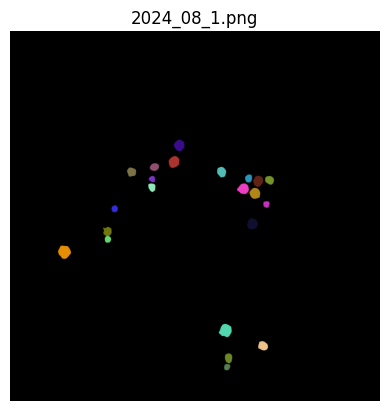

In [86]:
xml_file = f"../sample_data/annotations/{filename_substr}.xml"
bboxes = extract_bboxes_from_xml(xml_file)

merged_mask, areas = predict_masks_from_bboxes(predictor, bboxes)
print(merged_mask.shape)
np.save(f"{filename_substr}_areas.npy", areas)

plt.imshow(merged_mask, cmap='gray')
plt.axis('off')
plt.title(f"{filename_substr}.png")

mask_path = f'../sample_data/masks/{filename_substr}_mask.png'
cv2.imwrite(mask_path, merged_mask.astype(np.uint8) * 255)

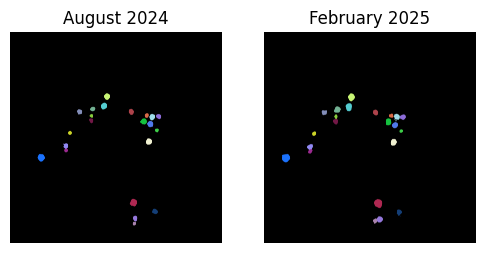

In [140]:
mask_1 = cv2.imread('../sample_data/masks/2024_08_1_mask.png')
mask_2 = cv2.imread('../sample_data/masks/2025_02_1_mask.png')

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(mask_1, cmap='gray'); axes[0].axis('off'); axes[0].set_title('August 2024')
axes[1].imshow(mask_2, cmap='gray'); axes[1].axis('off'); axes[1].set_title('February 2025')
plt.show()


In [141]:
masks_substr = ["2024_08_1", "2025_02_1"]  # add more as needed

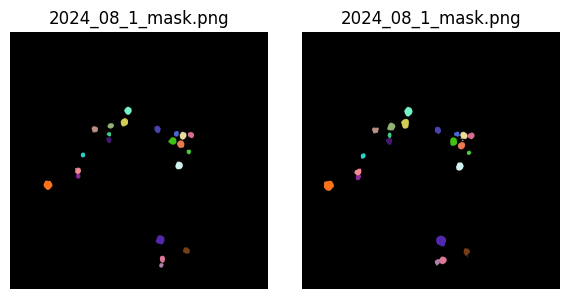

In [139]:
# update these paths to your images
img1_path = f'../sample_data/masks/{masks_substr[0]}_mask.png'
img2_path = f'../sample_data/masks/{masks_substr[1]}_mask.png'

# read color images with cv2 (BGR)
img1 = cv2.imread(img1_path, cv2.IMREAD_COLOR)
img2 = cv2.imread(img2_path, cv2.IMREAD_COLOR)

# convert to RGB for matplotlib
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) if img1 is not None else None
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) if img2 is not None else None

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(img1_rgb)
axes[0].axis('off')
axes[0].set_title(f'{masks_substr[0]}_mask.png')

axes[1].imshow(img2_rgb)
axes[1].axis('off')
axes[1].set_title(f'{masks_substr[0]}_mask.png')

plt.tight_layout()
plt.show()

Now let's overlay these coloured masks over the original images for visualisation using our helper function and save them.

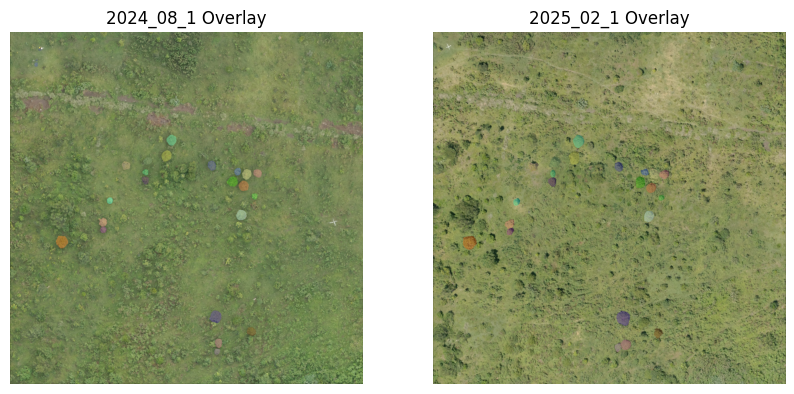

In [143]:
substrs = ["2024_08_1", "2025_02_1"]
image1 = cv2.imread(f'../sample_data/images/{substrs[0]}.png', cv2.IMREAD_COLOR_RGB)
image2 = cv2.imread(f'../sample_data/images/{substrs[1]}.png', cv2.IMREAD_COLOR_RGB)

overlayed1 = overlay_colored_mask(image, mask_1, alpha=0.4, mask_bgr=True)
overlayed2 = overlay_colored_mask(image2, mask_2, alpha=0.4, mask_bgr=True)

cv2.imwrite(f'../sample_data/overlays/{substrs[0]}_overlay.png', cv2.cvtColor(overlayed1, cv2.COLOR_RGB2BGR))
cv2.imwrite(f'../sample_data/overlays/{substrs[1]}_overlay.png', cv2.cvtColor(overlayed2, cv2.COLOR_RGB2BGR))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(overlayed1); axes[0].axis('off'); axes[0].set_title(f'{substrs[0]} Overlay')
axes[1].imshow(overlayed2); axes[1].axis('off'); axes[1].set_title(f'{substrs[1]} Overlay')
plt.show()

Let's load our overlayed images from file and plot them to make sure they were saved correctly.

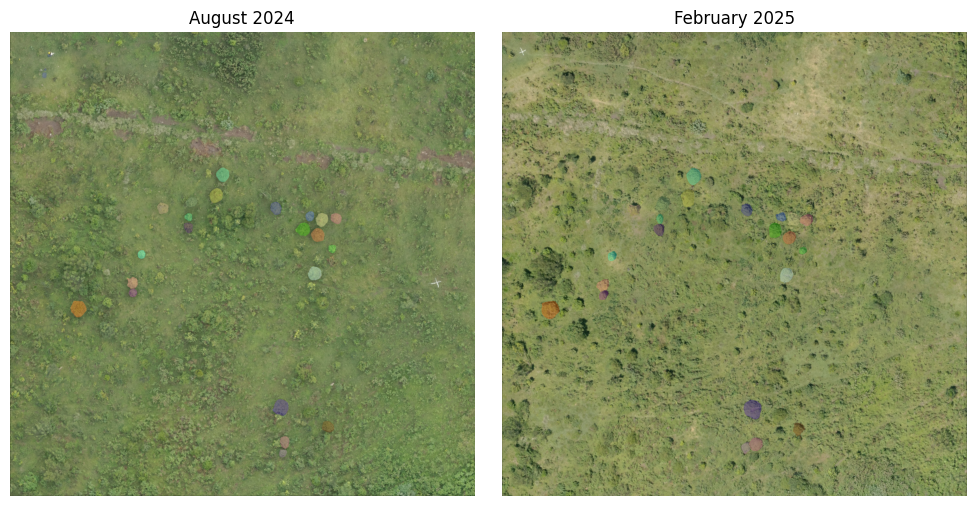

In [144]:
overlay_2024 = cv2.imread('../sample_data/overlays/2024_08_1_overlay.png', cv2.IMREAD_COLOR_RGB)
overlay_2025 = cv2.imread('../sample_data/overlays/2025_02_1_overlay.png', cv2.IMREAD_COLOR_RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(overlay_2024)
axes[0].set_title('August 2024')
axes[0].axis('off')

axes[1].imshow(overlay_2025)
axes[1].set_title('February 2025')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('../sample_data/overlays/overlay_comparison.png', dpi=1200)
plt.show()

In [146]:
ca2024 = np.load('2024_08_1_areas.npy')
ca2025 = np.load('2025_02_1_areas.npy')

In [167]:
# Set seed for reproducibility
np.random.seed(42)
N_TREES = len(ca2024)

# 1. Generate the 'colors' list (22 distinct colors)
# Use a colormap to get distinct colors, then convert to hex for consistency
colors = [(r/255, g/255, b/255) for r, g, b in random_colors]
my_cm = ListedColormap(colors, name='my_custom_cmap')
colors = [to_hex(my_cm(i)) for i in range(N_TREES)]

# 2. Create a DataFrame for easier management
df = pd.DataFrame({
    'Tree_ID': [f'Tree {i+1}' for i in range(N_TREES)],
    'ca2024': ca2024,
    'ca2025': ca2025,
    'Color': colors
})


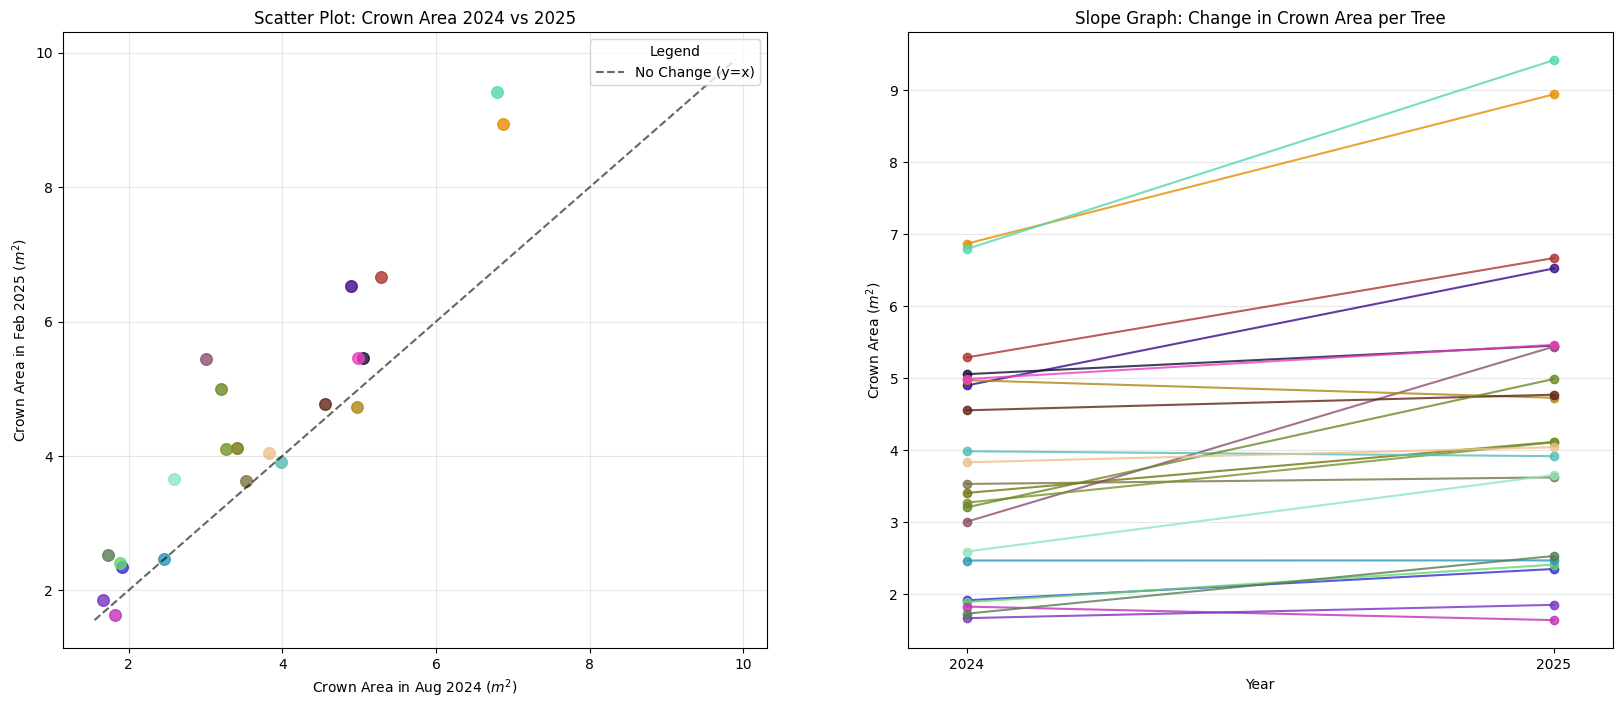

In [168]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))


# --- SCATTER PLOT ---

# Loop to plot each tree with its unique color and label
for i in range(N_TREES):
    tree_id = df.loc[i, 'Tree_ID']
    color = df.loc[i, 'Color']
    axes[0].scatter(df.loc[i, 'ca2024'], df.loc[i, 'ca2025'], color=color, s=70, alpha=0.8)

# Add 1:1 line (y=x)
max_val = max(df['ca2024'].max(), df['ca2025'].max()) * 1.05
min_val = min(df['ca2024'].min(), df['ca2025'].min()) * 0.95
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.6, label='No Change (y=x)'); axes[0].set_title('Scatter Plot: Crown Area 2024 vs 2025')
axes[0].set_xlabel('Crown Area in Aug 2024 ($m^2$)'); axes[0].set_ylabel('Crown Area in Feb 2025 ($m^2$)')
axes[0].legend(title='Legend', bbox_to_anchor=(1, 1), loc='upper right', ncol=2); axes[0].grid(True, alpha=0.3)



# --- SLOPE GRAPH ---

# Prepare the data for the slope graph (Time 1 and Time 2 points for each tree)
df_melted = df.melt(id_vars=['Tree_ID', 'Color'], value_vars=['ca2024', 'ca2025'], var_name='Year', value_name='Area')

# Map year names to numeric positions for plotting
year_mapping = {'ca2024': 0, 'ca2025': 1}
df_melted['Year_Num'] = df_melted['Year'].map(year_mapping)

# Loop to plot each tree's line segment and points
for tree_id in df['Tree_ID'].unique():
    tree_data = df_melted[df_melted['Tree_ID'] == tree_id]
    color = tree_data['Color'].iloc[0]
    axes[1].plot(tree_data['Year_Num'], tree_data['Area'], color=color, marker='o', linestyle='-', alpha=0.8)

axes[1].set_xticks([0, 1], ['2024', '2025']); axes[1].set_xlim(-0.1, 1.1) # Add slight padding
axes[1].set_title('Slope Graph: Change in Crown Area per Tree'); axes[1].set_ylabel('Crown Area ($m^2$)'); axes[1].set_xlabel('Year')
axes[1].grid(True, axis='y', alpha=0.3)

We can see clearly that a majority of tree crowns have increased in size between August and February.